In [1]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import *
import math
import re
import os
import seaborn as sbn
sbn.set_style("whitegrid")

import matplotlib.image as mpimg
import glob

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


-0.0795757188849


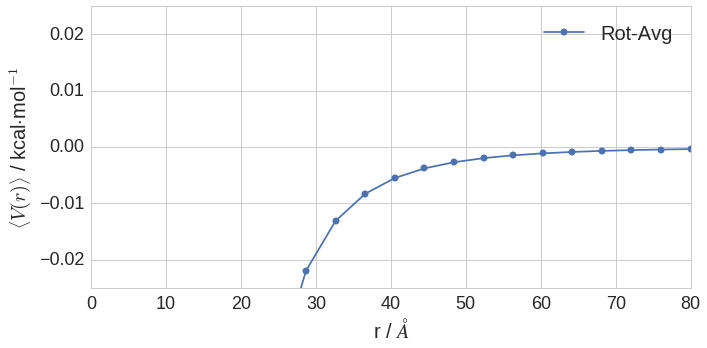

In [2]:
#Theory: a rotationally-averaged charge-dipole potential
#Function form : psi(r) = -1/3kBT  (qmu/4pi*eps0)* (1/r^4)
val_r = linspace(5,80,20) #vector r - start from 5 since around 0 we have astronomical values
thpot = [] #list of values for theory
q1, mu, epsw = 1, (2.35*0.20819434), 82.0 #  charge q1 = 1e , dipole mu = 0.47 eA, dielectric TIP3P water epsw = 82.0
one_over_four_pi_eps0 = 332.14711959 # kcal Ang/(mol e^2)
#parameters
invkT3 = -1/(3*(0.0019872041*298.0)) #the inverse -1/3KT
#cycle and store the values
for r in val_r:
    qdip =  (one_over_four_pi_eps0)*(q1*mu)
    qkt = (invkT3*qdip**2)*(1/r**4)
    thpot.append(qkt)

#plot
color = sbn.color_palette() #define colors from seaborn
#####################################
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(val_r, thpot,color=color[0],marker="o",label="Rot-Avg")
ax.set_ylim(-0.025,0.025)
ax.set_xlabel("r / $\AA$",fontsize=20)
ax.tick_params(labelsize=18)
ax.legend(loc="best",fontsize=20)
ax.set_ylabel(r"$\left \langle V(r) \right \rangle$ / kcal$\cdot$mol$^{-1}$" ,fontsize=20)
plt.tight_layout()
#plt.savefig("charge-dipole_RF.png",transparent=True,dpi=300)

for i,val in enumerate(thpot):
    if math.floor(val_r[i])==20:
        print(val)
 

In [3]:
def reaction_field(start,end,rcutoff):
    
    distance = linspace(start,end,20)
    avgpot = []
    reactfield = []
    #constant
    q1, mu, epsw = 1, (2.35*0.20819434), 82.0 #  charge q1 = 1e , dipole mu = 0.47 eA, dielectric TIP3P water epsw = 82.0
    one_over_four_pi_eps0 = 332.14711959 # kcal/mol e^2
    #parameters
    invkT3 = -1/(3*(0.0019872041*298.0)) #kB = 0.0019872041 kcal/(mol K)
    rcut = rcutoff #cutoff at 30 Angstrom
    #terms with the espw
    eps1 = ( epsw - 1)/(1 + 2*epsw)
    eps2 = 3/(1+2*epsw)
    epssq = (eps1 + eps2)**2
    #cycle and store the values
    for r in distance:
        #charge term which is constant for all the potentials
        charge =  (one_over_four_pi_eps0)*(q1*mu)
        #coupled with boltzmann term and distance r**-4
        boltz = invkT3*(charge**2)*(r**-4)
        #reaction field terms
        radii = (r**3/rcut**3) #ratio between r and cutoff
        #reaction field terms
        react = radii*eps1*(eps1*(radii-2)-2*eps2)
        #total potential
        total = boltz*4*(epssq + react)
        #store values
        avgpot.append(total)
        reactfield.append(4*react)
    
     #   rfield.append(4*(epssq+react))
    
    return avgpot,reactfield, distance

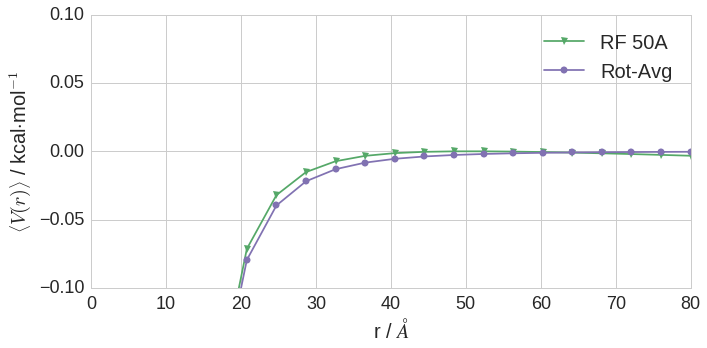

In [4]:
#Rotationally-averaged charge-dipole potential in a reaction field
#Functional form:
#(-4/3*kT)*(qu/4pieps0*r**2)**2 * ( (esp1 + esp2)**2 + (r**3/a**3)*eps1*(eps1*(r**3/a**3 - 2) - 2*eps2) ) 
avg15,react15,val_r = reaction_field(5,80,15)

avg30,react30,val_r = reaction_field(5,80,30)
avg50,react50,val_r = reaction_field(5,80,50)
avg80,react80,val_r = reaction_field(5,80,80)


 
#plot
fig, axarr = plt.subplots(figsize=(10,5))
#axarr.plot(val_r, avg15,color=color[0],marker="o",label="RF 15A") # ion-dipole reaction field
axarr.set_ylim(-0.1,0.1)
axarr.plot(val_r,avg50,color=color[1],marker="v",label="RF 50A")
#axarr.plot(val_r,avg80,color=color[2],marker="^",label="RF 80A")
axarr.plot(val_r, thpot,color=color[3],marker="o",label="Rot-Avg")     # theory rotationally averaged
#axarr[0].plot(val_r, rfield,color=color[2],marker="o",label="RF ")        # reaction field contribution
axarr.set_xlabel("r / $\AA$",fontsize=20)
axarr.tick_params(labelsize=18)
axarr.legend(loc="best",fontsize=20)
axarr.set_ylabel(r"$\left \langle V(r) \right \rangle$ / kcal$\cdot$mol$^{-1}$" ,fontsize=20)
#axarr.set_xlim(5,10)
#axarr.set_ylim(-0.1,0.1)
plt.tight_layout()

#plt.savefig("RFComparison_detail.png",dpi=300,transparent=True)

In [5]:
def store_values(infile,distance=False):
    
    potential = []
    error = []
    dist = []
    for line in infile.readlines():
        
        pot = float(line.split(",")[1])
        r = float(line.split(",")[0])
        err = float(line.split(",")[2])
        potential.append(pot)
        error.append(err)
        if distance:
            dist.append(r)
        else:
            continue
            
    if distance:
        return potential,error,dist
    
    else:
        return potential,error
        
        
        

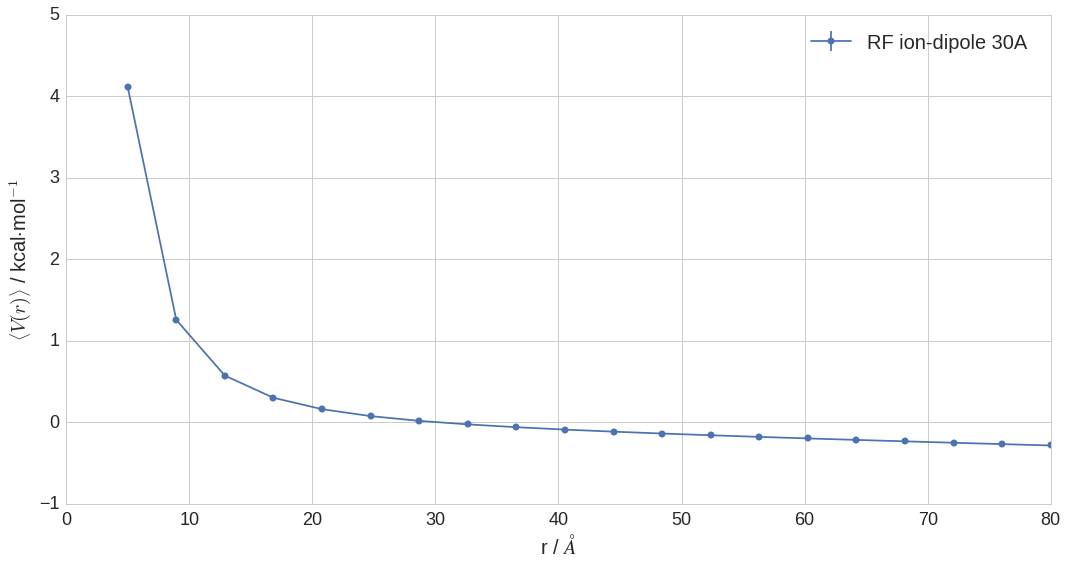

In [7]:
#ideal dipole test: simulation from 5 to 80 angstrom in 20 points
#here I have simulated an ideal dipole interacting with a charge (+1 Na+) in a reaction field with 30 A cutoff
#to explore all teh possible orientations I have adopted a rotation matrix approach, creating 1'500'000 possible 
#orientations

res30 = open("sire_test/ideal_dipole/simulations/30angstrom/r_coul.dat","r") #inputfiles: distance(r) potential  std deviation
#res50 = open("sire_test/ideal_dipole/simulations/50angstrom/r_coul.dat","r") #inputfiles: distance(r) potential  std deviation
#res80 = open("sire_test/ideal_dipole/simulations/80angstrom/r_coul.dat","r") #inputfiles: distance(r) potential  std deviation

#cycle and store
pot30,err30,distance = store_values(res30,True)
#pot50,err50 = store_values(res50)
#pot80,err80 = store_values(res80)

#plot
color = sbn.color_palette()
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.errorbar(distance, pot30,color=color[0],yerr=err30,ecolor=color[0],marker="o",label="RF ion-dipole 30A ")
#ax.errorbar(distance, pot50,color=color[1],yerr=err50,ecolor=color[1],marker="o",label="RF ion-dipole 50A ")
#ax.errorbar(distance, pot80,color=color[2],yerr=err80,ecolor=color[2],marker="o",label="RF ion-dipole 80A ")

#ax.plot(distance, pot30,color=color[0],marker="o",label="RF ion-dipole 30A ")
#ax.plot(distance, pot50,color=color[1],marker="o",label="RF ion-dipole 50A ")
#ax.plot(distance, pot80,color=color[2],marker="o",label="RF ion-dipole 80A ")

ax.set_xlabel("r / $\AA$",fontsize=20)
ax.tick_params(labelsize=18)
ax.set_ylabel(r"$\left \langle V(r) \right \rangle$ / kcal$\cdot$mol$^{-1}$" ,fontsize=20) 
#ax.set_xlim(20,80)
#ax.set_ylim(-0.001,0.001)
ax.legend(loc="best",fontsize=20)
plt.tight_layout()
plt.savefig("Charge-Dipole_plot_err.png",transparent=True,dpi=300)


/usr/local/lib/python2.7/dist-packages/matplotlib-1.5.0rc2_109.g08acc8d-py2.7-linux-x86_64.egg/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The normal aspect was deprecated in version 1.2. Use auto instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


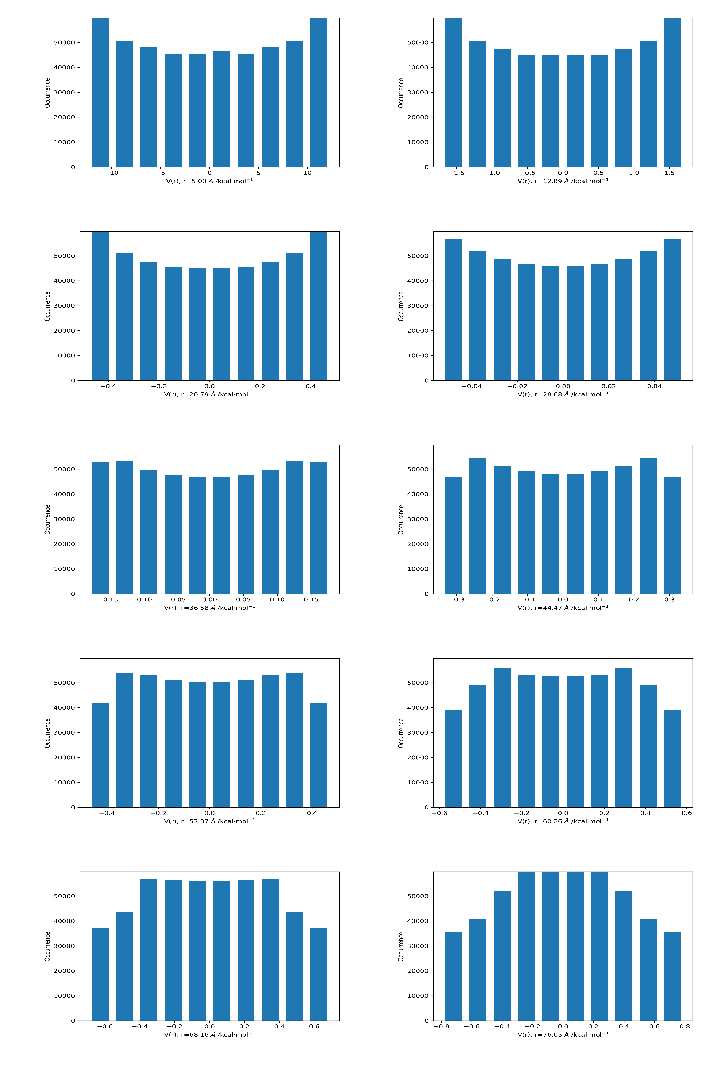

In [10]:
#histogram for ideal dipole simulations
dist_order = linspace(5,80,20)
#10 images subplots: 2 rows 5 columns
col = 0
row = 0 
fig,ax = plt.subplots(5,2,figsize=(10,15))
counter = 0
for dist in dist_order:
    if counter%2==0:
        img = "sire_test/ideal_dipole/simulations/30angstrom/histograms/pot_%.4f.png" % dist 
        inimg = mpimg.imread(img)
        if row==2:
            col+=1 
            row =0  
            ax[col,row].imshow(inimg,aspect="normal",interpolation="none")
            ax[col,row].axis("off")
            row+=1
        else:
            ax[col,row].imshow(inimg,aspect="normal",interpolation="none")
            ax[col,row].axis("off")
            row+=1
        counter+=1
    else:
        counter+=1

fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.show()

#fig.savefig("Charge-Dipole_histograms.png",transparent=True,dpi=300) #when you save th eimage is pretty clear


In [7]:
def histo_maker(ax,values,r):
    hist,bins = histogram(values,bins=10)
    width = 0.7*(bins[1] - bins[0])
    center = (bins[:-1] + bins[1:])/2
    ax.bar(center,hist,align="center",width=width)
    x_axis_name = r"V(r), r=%.2f $\AA$ /kcal$\cdot$mol$^{-1}$" % r
    ax.set_xlabel(x_axis_name,fontsize=12)
    ax.set_ylabel("Occurrence",fontsize=12)
    ax.tick_params(axis='both', length=0, labelsize=8)
    ax.set_title("Distance %.2f" %r)
    #ax.tight_layout()

def run_avg(values):
    counter = 0 
    avg = 0.0
    var=0.0
    
    for val in values:
        if counter==0:
            avg = val
            var = 0.0
            counter+=1
        else:
            tmp = avg
            avg = avg + (val - avg)/counter
            var = var + (val - tmp)*(val - avg)
            counter+=1
    
    var = var/(counter-1) #variance
    stddev = math.sqrt(var)
    return avg,stddev


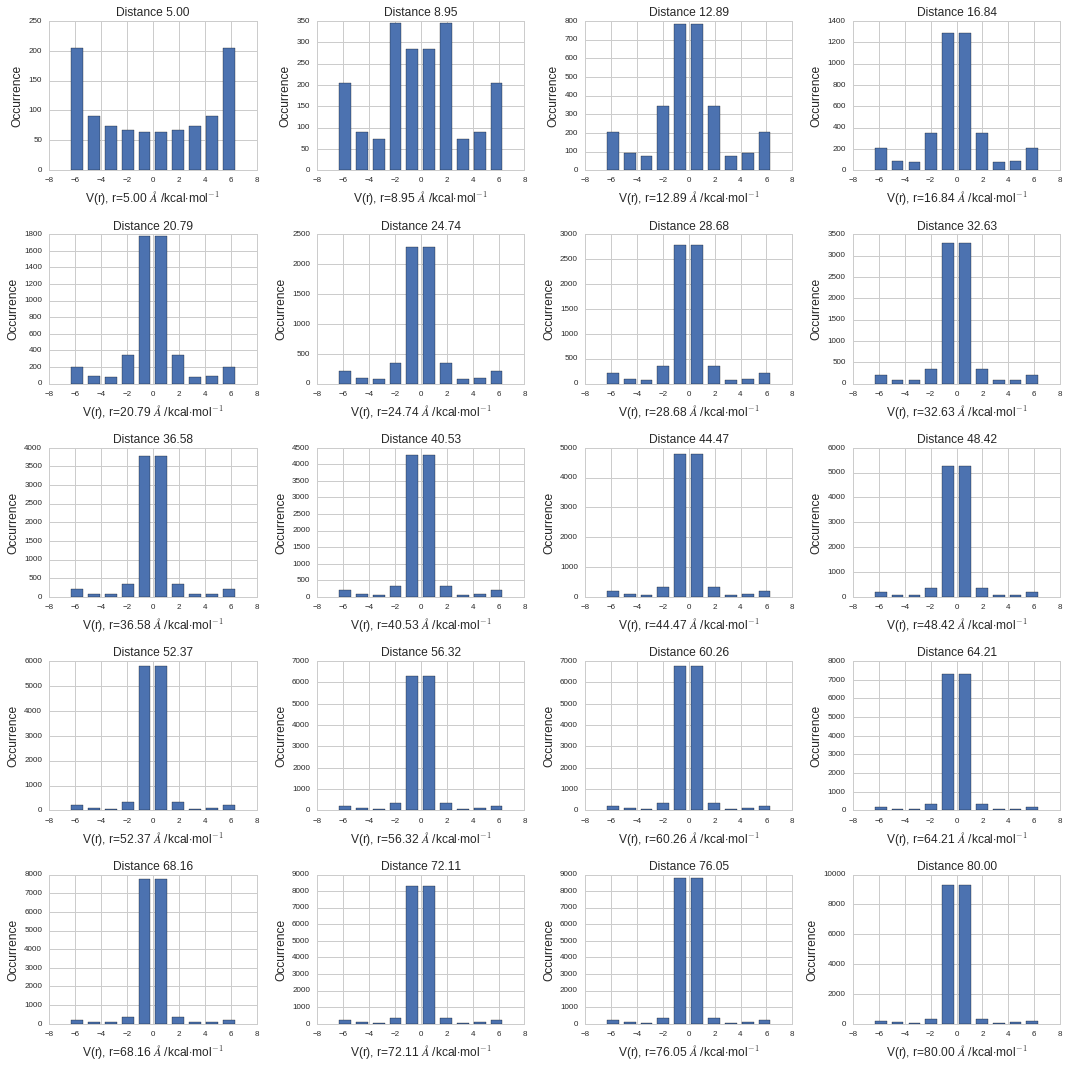

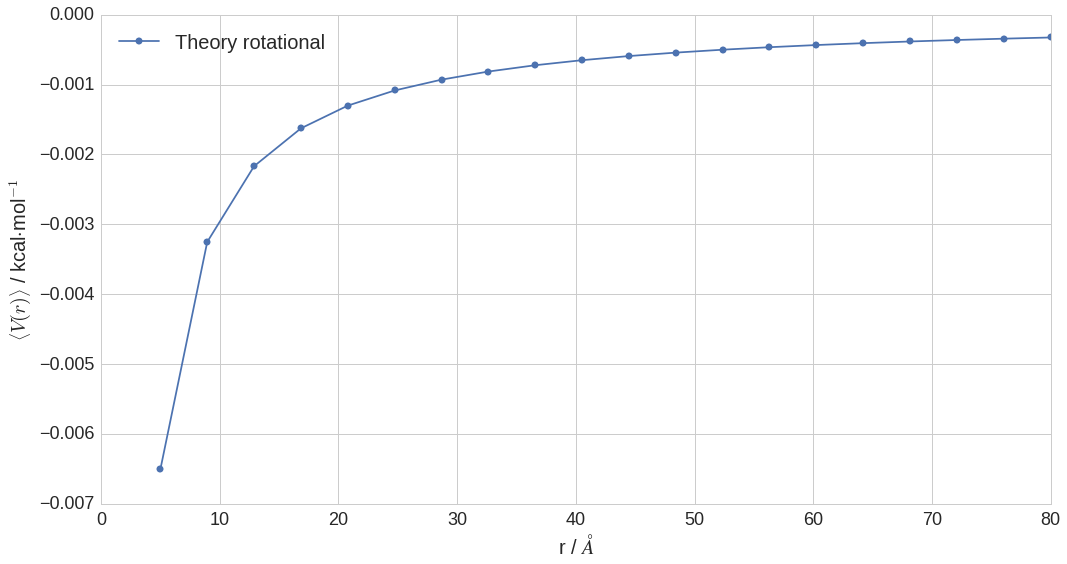

In [8]:
#what if I am simulating the theoretical charge-dipole potential:
#V = one_over_4pi*q*mu*cos(theta) * 1/r**2

q1, mu, epsw = 1, (2.35*0.20819434), 82.0 #  charge q1 = 1e , dipole mu = 0.47 eA, dielectric TIP3P water epsw = 82.0
one_over_four_pi_eps0 = 332.14711959 # kcal/mol e^2
#constant term
charge = one_over_four_pi_eps0*q1*mu
distances= linspace(5,80,20)
theta = linspace(0,math.pi,1000)

avg_pot = []
std_pot = []
nrgs = []
#20 plots in total, so divide in 5 columns, 4 rows
fig,ax = plt.subplots(5,4,figsize=(15,15))
col = 0
row = 0

for r in distances:
    for t in theta:
        nrg = charge*(math.cos(t))*(1/r**2)
        nrgs.append(nrg)

    if row == 4:
        col+=1
        row = 0
        #print("Distance %.2f for col %d and row %d" % (r,col,row))
        histo_maker(ax[col,row],nrgs,r)
        avg,dev =run_avg(nrgs)
        avg_pot.append(avg)
        std_pot.append(dev)
        row+=1
    else:
        histo_maker(ax[col,row],nrgs,r)
        #print("Distance %.2f for col %d and row %d" % (r,col,row))
        avg,dev = run_avg(nrgs)
        avg_pot.append(avg)
        std_pot.append(dev)
        row+=1

        



fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
fig.savefig("Ideal-Charge-Dipole_histogram.png",dpi=300,transparent=True)
plt.show()

#plot the average potential
color = sbn.color_palette()
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
#ax.errorbar(distances, avg_pot,color=color[0],yerr=std_pot,ecolor=color[0],marker="o",label="Theory")
ax.plot(distances, avg_pot,color=color[0],marker="o",label="Theory rotational")

ax.set_xlabel("r / $\AA$",fontsize=20)
ax.tick_params(labelsize=18)
ax.set_ylabel(r"$\left \langle V(r) \right \rangle$ / kcal$\cdot$mol$^{-1}$" ,fontsize=20) 
#ax.set_xlim(20,80)
ax.legend(loc="best",fontsize=20)
plt.tight_layout()
#plt.savefig("Charge-Dipole_plot.png",transparent=True,dpi=300)

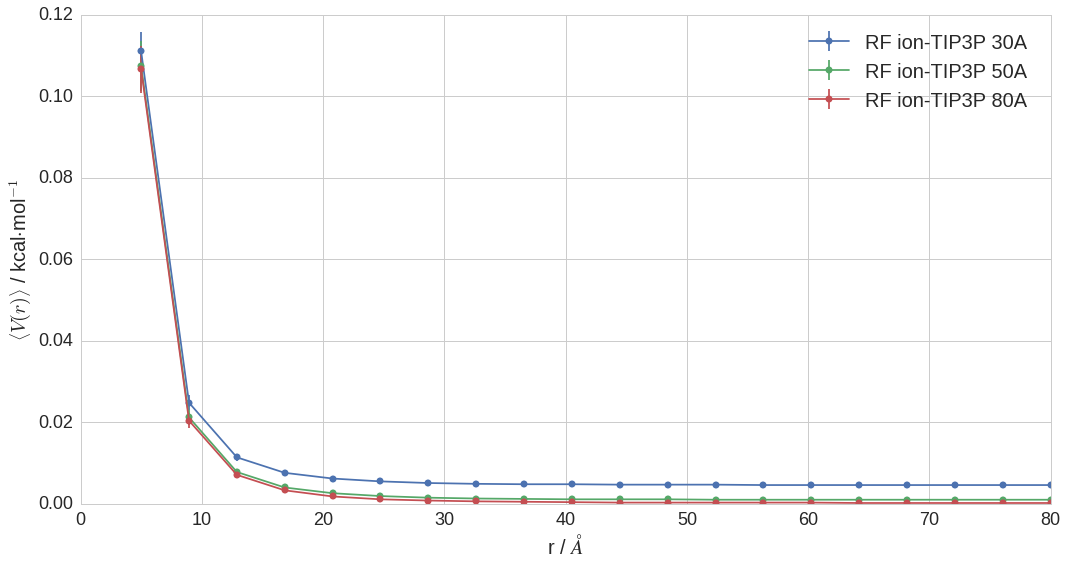

In [40]:
#water test: simulation from 5 to 80 angstrom in 20 points

res30 = open("sire_test/water/simulations/30angstrom/r_coul.dat","r") #inputfiles: distance(r) potential  std deviation
res50 = open("sire_test/water/simulations/50angstrom/r_coul.dat","r") #inputfiles: distance(r) potential  std deviation
res80 = open("sire_test/water/simulations/80angstrom/r_coul.dat","r") #inputfiles: distance(r) potential  std deviation

#cycle and store
wat30,waterr30,distance = store_values(res30,True)
wat50,waterr50 = store_values(res50)
wat80,waterr80 = store_values(res80)

#plot
color = sbn.color_palette()
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.errorbar(distance, wat30,color=color[0],yerr=waterr30,ecolor=color[0],marker="o",label="RF ion-TIP3P 30A ")
ax.errorbar(distance, wat50,color=color[1],yerr=waterr50,ecolor=color[1],marker="o",label="RF ion-TIP3P 50A ")
ax.errorbar(distance, wat80,color=color[2],yerr=waterr80,ecolor=color[2],marker="o",label="RF ion-TIP3P 80A ")

ax.set_xlabel("r / $\AA$",fontsize=20)
ax.tick_params(labelsize=18)
ax.set_ylabel(r"$\left \langle V(r) \right \rangle$ / kcal$\cdot$mol$^{-1}$" ,fontsize=20) 
#ax.set_xlim(0,30)
ax.legend(loc="best",fontsize=20)

plt.tight_layout()
plt.savefig("Water-dipole_plot.png",transparent=True,dpi=300)


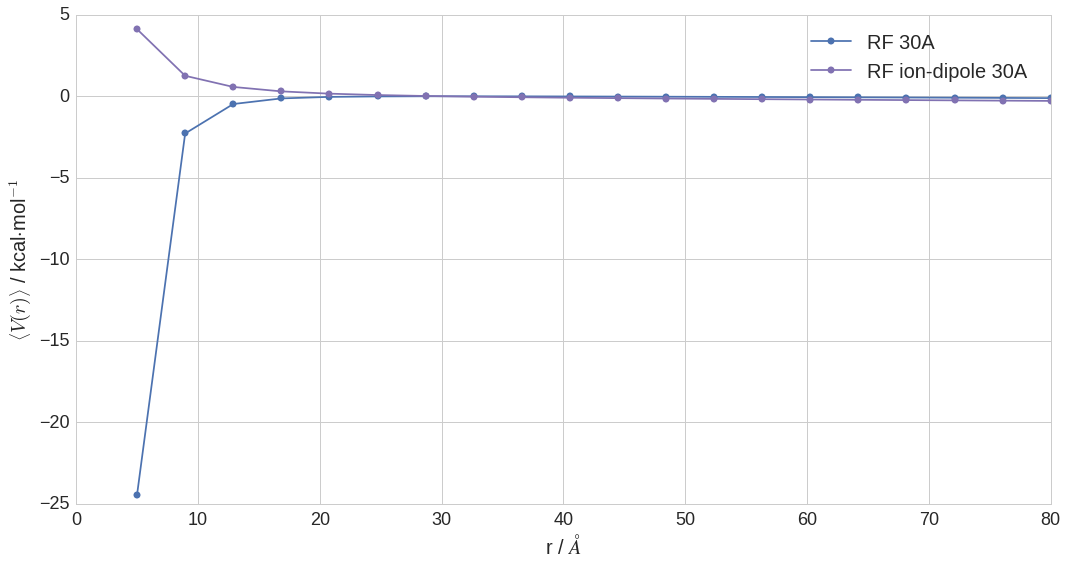

In [9]:
#Comparison between all the curves
color = sbn.color_palette(n_colors=8)
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

#Derived RF behaviour
ax.plot(val_r, avg30,color=color[0],marker="o",label="RF 30A") # ion-dipole reaction field
#ax.plot(val_r,avg50,color=color[1],marker="v",label="RF 50A")
#ax.plot(val_r,avg80,color=color[2],marker="^",label="RF 80A")

#Theory
#ax.plot(val_r,thpot,color=color[3],marker="s",label="RF Theory")

#Water
#ax.plot(distance, wat30,color=color[4],marker="d",label="RF ion-TIP3P 30A")
#ax.plot(distance, wat50,color=color[5],marker="d",label="RF ion-TIP3P 50A")
#ax.plot(distance, wat80,color=color[6],marker="d",label="RF ion-TIP3P 80A")

#Ideal Dipole
ax.plot(distance, pot30,color=color[3],marker="o",label="RF ion-dipole 30A ")
#ax.plot(distance, pot50,color=color[4],marker="o",label="RF ion-dipole 50A ")
#ax.plot(distance, pot80,color=color[5],marker="o",label="RF ion-dipole 80A ")


ax.set_xlabel("r / $\AA$",fontsize=20)
ax.tick_params(labelsize=18)
ax.legend(loc="best",fontsize=20)
ax.set_ylabel(r"$\left \langle V(r) \right \rangle$ / kcal$\cdot$mol$^{-1}$" ,fontsize=20) 
#ax.set_xlim(20,80)
#ax.set_ylim(-0.1,0.1)
plt.tight_layout()



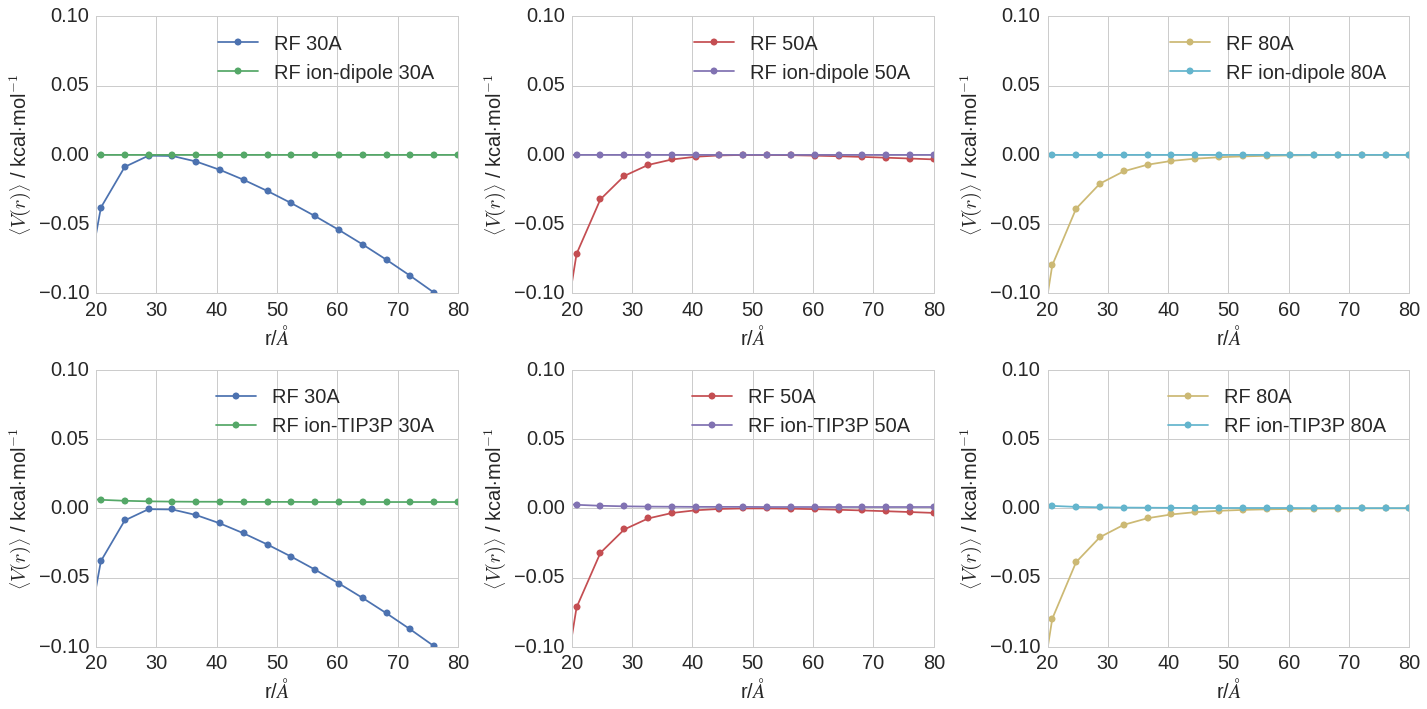

In [41]:
#Comparison between all the curves
color = sbn.color_palette(n_colors=8)
#create subplots for  RF-Ion 30 / 50 / 80  and  RF-Water 30/ 50 /80
fig,ax = plt.subplots(2,3,figsize=(20,10))

#Derived RF vs BWRF ideal ion simulation 30 A
ax[0][0].plot(val_r, avg30,color=color[0],marker="o",label="RF 30A") # ion-dipole reaction field
ax[0][0].plot(distance,pot30,color=color[1],marker="o",label="RF ion-dipole 30A ")
ax[0][0].set_xlabel("r/$\AA$",fontsize=20)
ax[0][0].tick_params(labelsize=20)
ax[0][0].legend(loc="best",fontsize=20)
ax[0][0].set_ylabel(r"$\left \langle V(r) \right \rangle$ / kcal$\cdot$mol$^{-1}$" ,fontsize=20) 
ax[0][0].set_xlim(20,80)
ax[0][0].set_ylim(-0.1,0.1)
#50 A
ax[0][1].plot(val_r, avg50,color=color[2],marker="o",label="RF 50A") # ion-dipole reaction field
ax[0][1].plot(distance,pot50,color=color[3],marker="o",label="RF ion-dipole 50A ")
ax[0][1].set_xlabel("r/$\AA$",fontsize=20)
ax[0][1].tick_params(labelsize=20)
ax[0][1].legend(loc="best",fontsize=20)
ax[0][1].set_ylabel(r"$\left \langle V(r) \right \rangle$ / kcal$\cdot$mol$^{-1}$" ,fontsize=20) 
ax[0][1].set_xlim(20,80)
ax[0][1].set_ylim(-0.1,0.1)
#80 A
ax[0][2].plot(val_r, avg80,color=color[4],marker="o",label="RF 80A") # ion-dipole reaction field
ax[0][2].plot(distance,pot80,color=color[5],marker="o",label="RF ion-dipole 80A ")
ax[0][2].set_xlabel("r/$\AA$",fontsize=20)
ax[0][2].tick_params(labelsize=20)
ax[0][2].legend(loc="best",fontsize=20)
ax[0][2].set_ylabel(r"$\left \langle V(r) \right \rangle$ / kcal$\cdot$mol$^{-1}$" ,fontsize=20) 
ax[0][2].set_xlim(20,80)
ax[0][2].set_ylim(-0.1,0.1)

#WATER
#Derived RF vs BWRF water at 30
ax[1][0].plot(val_r, avg30,color=color[0],marker="o",label="RF 30A") # ion-dipole reaction field
ax[1][0].plot(distance,wat30,color=color[1],marker="o",label="RF ion-TIP3P 30A ")
ax[1][0].set_xlabel("r/$\AA$",fontsize=20)
ax[1][0].tick_params(labelsize=20)
ax[1][0].legend(loc="best",fontsize=20)
ax[1][0].set_ylabel(r"$\left \langle V(r) \right \rangle$ / kcal$\cdot$mol$^{-1}$" ,fontsize=20) 
ax[1][0].set_xlim(20,80)
ax[1][0].set_ylim(-0.1,0.1)
#50 A
ax[1][1].plot(val_r, avg50,color=color[2],marker="o",label="RF 50A") # ion-dipole reaction field
ax[1][1].plot(distance,wat50,color=color[3],marker="o",label="RF ion-TIP3P 50A ")
ax[1][1].set_xlabel("r/$\AA$",fontsize=20)
ax[1][1].tick_params(labelsize=20)
ax[1][1].legend(loc="best",fontsize=20)
ax[1][1].set_ylabel(r"$\left \langle V(r) \right \rangle$ / kcal$\cdot$mol$^{-1}$" ,fontsize=20) 
ax[1][1].set_xlim(20,80)
ax[1][1].set_ylim(-0.1,0.1)
#80 A
ax[1][2].plot(val_r, avg80,color=color[4],marker="o",label="RF 80A") # ion-dipole reaction field
ax[1][2].plot(distance,wat80,color=color[5],marker="o",label="RF ion-TIP3P 80A ")
ax[1][2].set_xlabel("r/$\AA$",fontsize=20)
ax[1][2].tick_params(labelsize=20)
ax[1][2].legend(loc="best",fontsize=20)
ax[1][2].set_ylabel(r"$\left \langle V(r) \right \rangle$ / kcal$\cdot$mol$^{-1}$" ,fontsize=20) 
ax[1][2].set_xlim(20,80)
ax[1][2].set_ylim(-0.1,0.1)


plt.tight_layout()

fig.savefig("Superposition_curves.png",transparent=True,dpi=300)
